<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/causality_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pharringtonp19/business-analytics.git

Cloning into 'business-analytics'...
remote: Enumerating objects: 1210, done.
remote: Counting objects: 100% (827/827), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 1210 (delta 578), reused 601 (delta 422), pack-reused 383 (from 1)
Receiving objects: 100% (1210/1210), 21.35 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (706/706), done.


### **Import Packages**

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import jax.numpy as jnp
import jax
import seaborn as sb
from functools import partial

### **Read In Data Set**

In [3]:
df = pd.read_csv('/content/business-analytics/datasets/lifeExpectancy.csv')
df.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,67,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,92,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


In [5]:
df = df.loc[:, 'Year':'Life_expectancy']

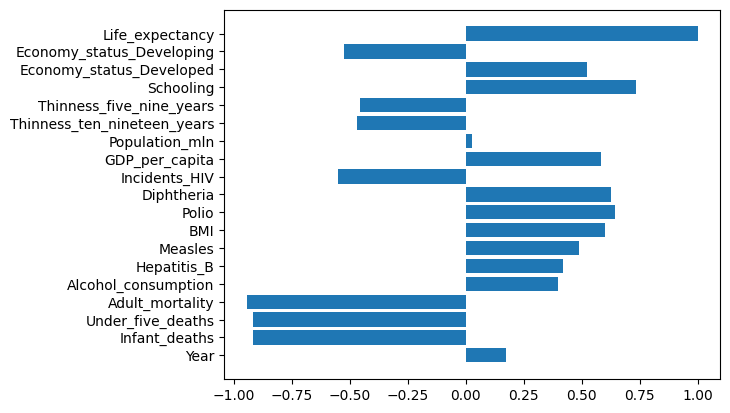

In [9]:
data = df.corr()['Life_expectancy']
plt.barh(data.index, data.values)
plt.show()

### **Create Function**

In [ ]:
def get_rsqrs(reg_formula):
  linear_model  = smf.ols(reg_formula, df)
  results = linear_model.fit()
  return results.rsquared_adj, results.rsquared

if dataset == 'brookline':
  get_rsqrs('price ~ beacon')
else:
  get_rsqrs('math ~ expenditure')

### **Store Results**

In [ ]:
# To Keep Track of Results
ordered_variables = []
optimal_adj_rsqr, optimal_rsqr = [], []

**Specify the dependent variable**

In [ ]:
dep_var = 'price' if dataset == 'brookline' else 'math'

**Create list of possible Right Hand Side Variables**

In [ ]:
if dataset == 'brookline':
  eligible_vars = df.columns.drop(['stNumber', 'stName', dep_var]).tolist()
  categorical_vars = ['buildingStyle']
else:
  eligible_vars = df.columns.drop(['Unnamed: 0', 'district', 'school', 'county', 'grades', dep_var]).tolist()

### **Create Dictionary of Variable Name and Regression String Format**

In [ ]:
eligible_vars = {key: key if key not in categorical_vars else f'C({key})' for key in eligible_vars}

### **Create Regression String**

In [ ]:
reg_formula = dep_var + ' ~ '

### **For Loop**

In [ ]:
for i in range(len(eligible_vars)):

  # Create a List of regression strings (one for each possible new independent variable)
  if i == 0:
    reg_formulas = list(map(lambda x : reg_formula + x, eligible_vars.values()))
  else:
    reg_formulas = list(map(lambda x : reg_formula + ' + ' + x, eligible_vars.values()))

  # Compute the Rsquared and Adjusted-Rsquared for each regression model
  results = np.array(list(map(get_rsqrs, reg_formulas)))

  # Extract the adjusted_rsquared_array (first column of results)
  adj_rsqrs = results[:,0]

  # Find the index with the largest adjusted_rsquared
  argmax_idx = np.argmax(adj_rsqrs)

  # Use the index to select the corresponding indpendent variable with the largest adjusted_rsquared
  new_rhs = list(eligible_vars.keys())[argmax_idx]
  new_rhs_repr =  list(eligible_vars.values())[argmax_idx]
  ordered_variables.append(new_rhs)

  # Update the Regression Formula
  reg_formula = reg_formula + ' + ' + new_rhs_repr

  # Update the list of potential independent variables
  del eligible_vars[new_rhs]

  # Use the index to retrieve the adjusted_rsquared and r_squared associated with that index
  adj_rsqr, rsqr  = results[argmax_idx]

  # Append the values
  optimal_adj_rsqr.append(adj_rsqr)
  optimal_rsqr.append(rsqr)

### **Plot**

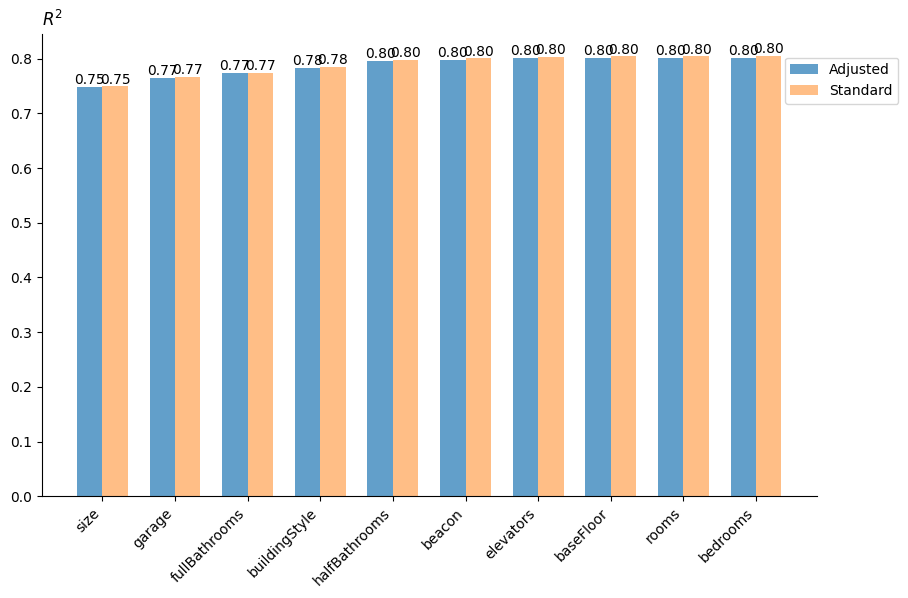

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define width for bars and positions for each pair of bars
bar_width = 0.35
x = np.arange(len(ordered_variables))

# Plot adjusted R-squared and R-squared bars side by side
bars_adj = ax.bar(x - bar_width / 2, optimal_adj_rsqr, width=bar_width, label="Adjusted", alpha=0.7)
bars_rs = ax.bar(x + bar_width / 2, optimal_rsqr, width=bar_width, label="Standard", alpha=0.5)

# Add labels, title, and angle the x-axis labels
ax.set_title(r"$R^2$", loc='left')
ax.set_xticks(x)
ax.set_xticklabels(ordered_variables, rotation=45, ha='right')
ax.legend(loc='center left', bbox_to_anchor=(.95, 0.9))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Display values above each bar
for bar in bars_adj:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bars_rs:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()